### Import Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt 

### Data Preprocessing

In [2]:
df = pd.read_csv('./dataset/esewa_airlines.csv')

In [3]:
df

,Unnamed: 0,account_id,last_modified_date,travelled_flight_name,total_amount
0,0,1.559470e+19,10/11/2023,BUDDHA AIR,6400.0
1,1,2.693080e+18,10/11/2023,BUDDHA AIR,5200.0
2,2,7.494540e+18,10/11/2023,SHREE AIRLINES,8800.0
3,3,1.493320e+19,10/11/2023,BUDDHA AIR,9001.0
4,4,1.682070e+19,10/11/2023,YETI AIRLINES,23200.0
...,...,...,...,...,...
1048570,1048570,6.846850e+18,8/7/2023,BUDDHA AIR,5000.0
1048571,1048571,1.029540e+19,8/7/2023,BUDDHA AIR,5000.0
1048572,1048572,1.340140e+19,8/7/2023,BUDDHA AIR,4200.0
1048573,1048573,6.879000e+18,8/7/2023,YETI AIRLINES,9200.0


In [4]:
del df['Unnamed: 0']

In [5]:
df.rename(columns={'last_modified_date': 'date'}, inplace=True)

In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%m/%d/%Y')

In [7]:
df = df.sort_values('date')

In [8]:
df.head()

,account_id,date,travelled_flight_name,total_amount
854347,1.332680e+19,2023-01-01,BUDDHA AIR,14400.0
854436,1.381450e+19,2023-01-01,BUDDHA AIR,12500.0
854437,1.810090e+17,2023-01-01,SAURYA AIRLINES,5495.0
854438,2.264800e+18,2023-01-01,BUDDHA AIR,15000.0
854439,4.300450e+18,2023-01-01,SHREE AIRLINES,7500.0


In [9]:
df = df.groupby('date')['total_amount'].sum().reset_index()
df.head()

,date,total_amount
0,2023-01-01,5225660.0
1,2023-01-02,5224795.2
2,2023-01-03,10351699.9
3,2023-01-04,9499251.0
4,2023-01-05,9953935.0


### Time Series Visualization

A *time-series data* is a series of data points or observations recorded at different or regular time intervals.

- The frequency of recorded data points may be hourly, daily, weekly, monthly, quarterly or annually

*Time-Series Forecasting* is the process of using a statistical model to predict future values of a time-series based on past results



In [10]:
def plot_df(data, x, y, title ="", dpi=300):
    plt.figure(figsize=(30,4), dpi=dpi) 
    plt.plot(data[x], data[y], color='red')
    plt.xticks(rotation=90) 
    plt.gca().set(title=title, xlabel=x, ylabel=y)
    plt.show()

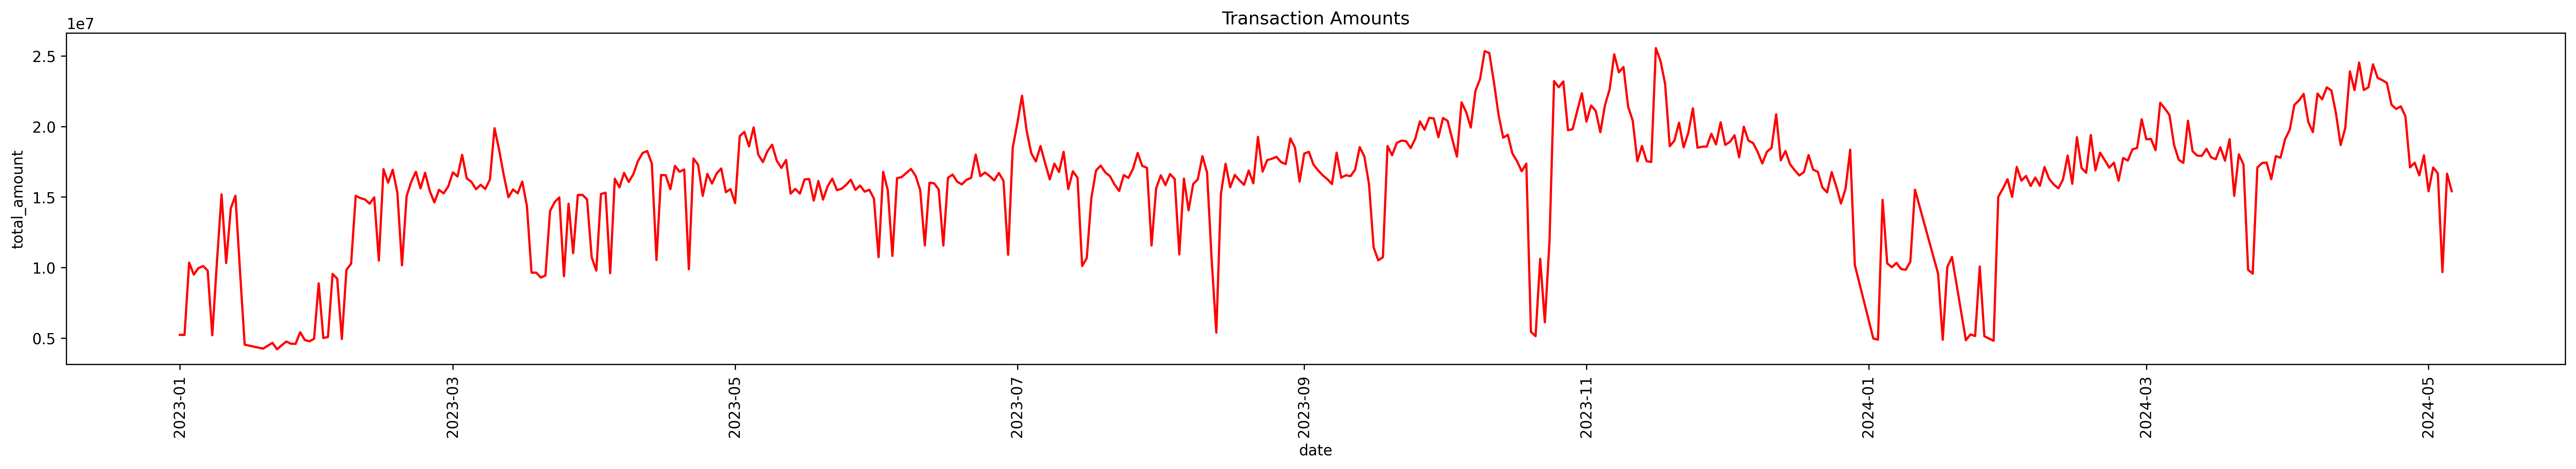

In [11]:
plot_df(data = df, x='date', y ='total_amount', title='Transaction Amounts')


### Stationarity

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time.

Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time

Autocorrelation of the series is nothing but the correlation of the series with its previous values.

A stationary time series is independent of seasonal effects as well.


In [12]:
df.set_index('date', inplace=True)

#### Test for Stationarity

We assume that the null hypothesis is the time series is non-stationary. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

In [13]:
def check_stationarity(series):
    # Taken from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = sts.adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [14]:
check_stationarity(df)

ADF Statistic: -3.938265
p-value: 0.001771
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Stationary


Here, p-value of 0.00177 is less than 0.05 so the time series is stationary

#### Difference between white noise and a stationary series 


- Like a stationary series, the white noise is also not a function of time. So, its mean and variance does not change over time. But the difference is that, the white noise is completely random with a mean of 0. In white noise there is no pattern.

- Mathematically, a sequence of completely random numbers with mean zero is a white noise.


#### Random White Noise

0.02919760970074209


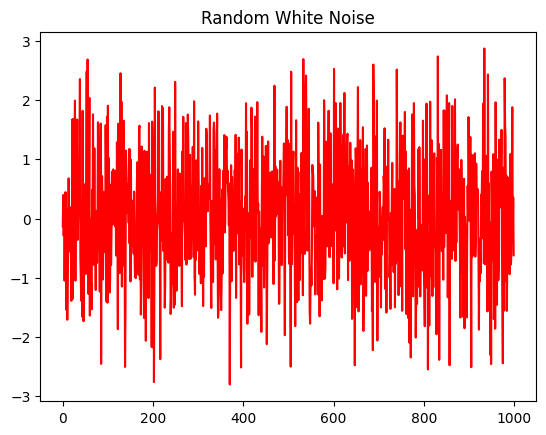

In [15]:
sr = pd.Series(data= np.random.randn(1000))

sr.plot(title='Random White Noise', color='r');
print(sr.mean())

### Components of a Time-Series¶

- Trend: The trend shows a general direction of the time series data over a long period of time. A trend can be increasing(upward), decreasing(downward), or horizontal(stationary)

- Seasonality: The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions.


- Irregular Variation: These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random


It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality and vice-versa.


In [16]:
plt.rcParams.update({'figure.figsize': (10, 7)})

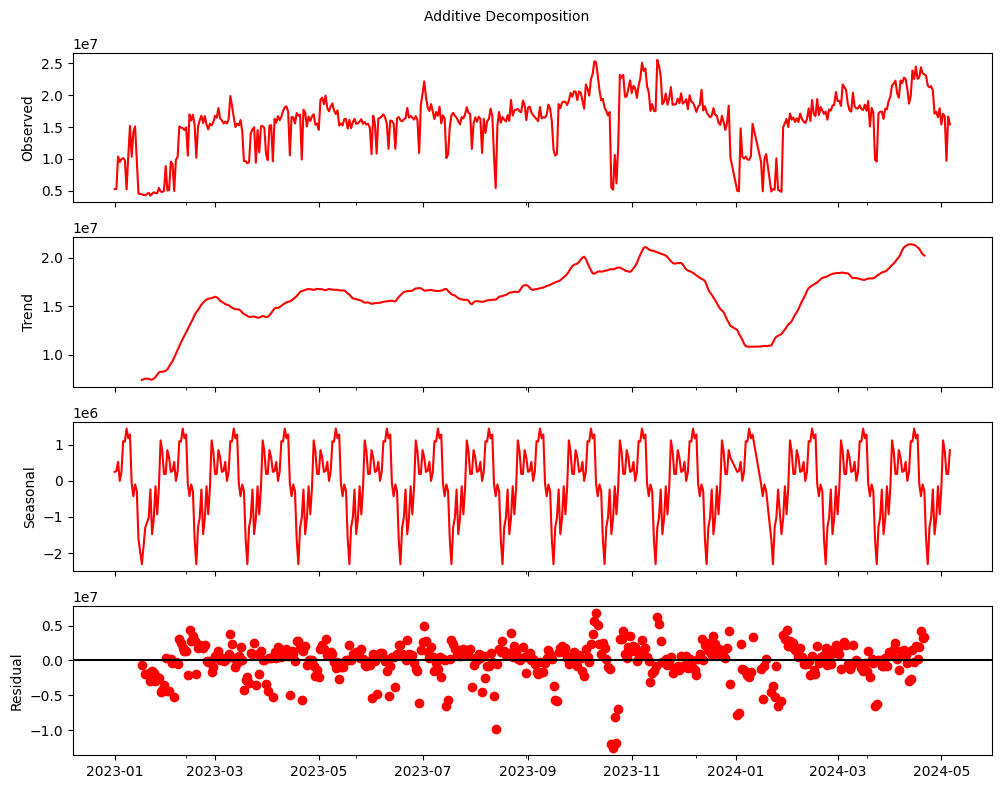

In [17]:
additive_decomposition = seasonal_decompose(df['total_amount'], model='additive', period=30)
multiplicative_decomposition = seasonal_decompose(df['total_amount'], model='multiplicative', period=30)

def plot_decomposition(decomposition, title, color):
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
    decomposition.observed.plot(ax=axes[0], color=color)
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1], color=color)
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2], color=color)
    axes[2].set_ylabel('Seasonal')
    axes[3].axhline(0, linestyle='-', color='black')
    axes[3].scatter(decomposition.resid.index, decomposition.resid, color=color)
    axes[3].set_ylabel('Residual')
    fig.suptitle(title, fontsize=10)
    plt.tight_layout()

plot_decomposition(additive_decomposition, 'Additive Decomposition', 'red')
# plot_decomposition(multiplicative_decomposition, 'Multiplicative Decomposition', 'red')

plt.show()


### ACF and PACF

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

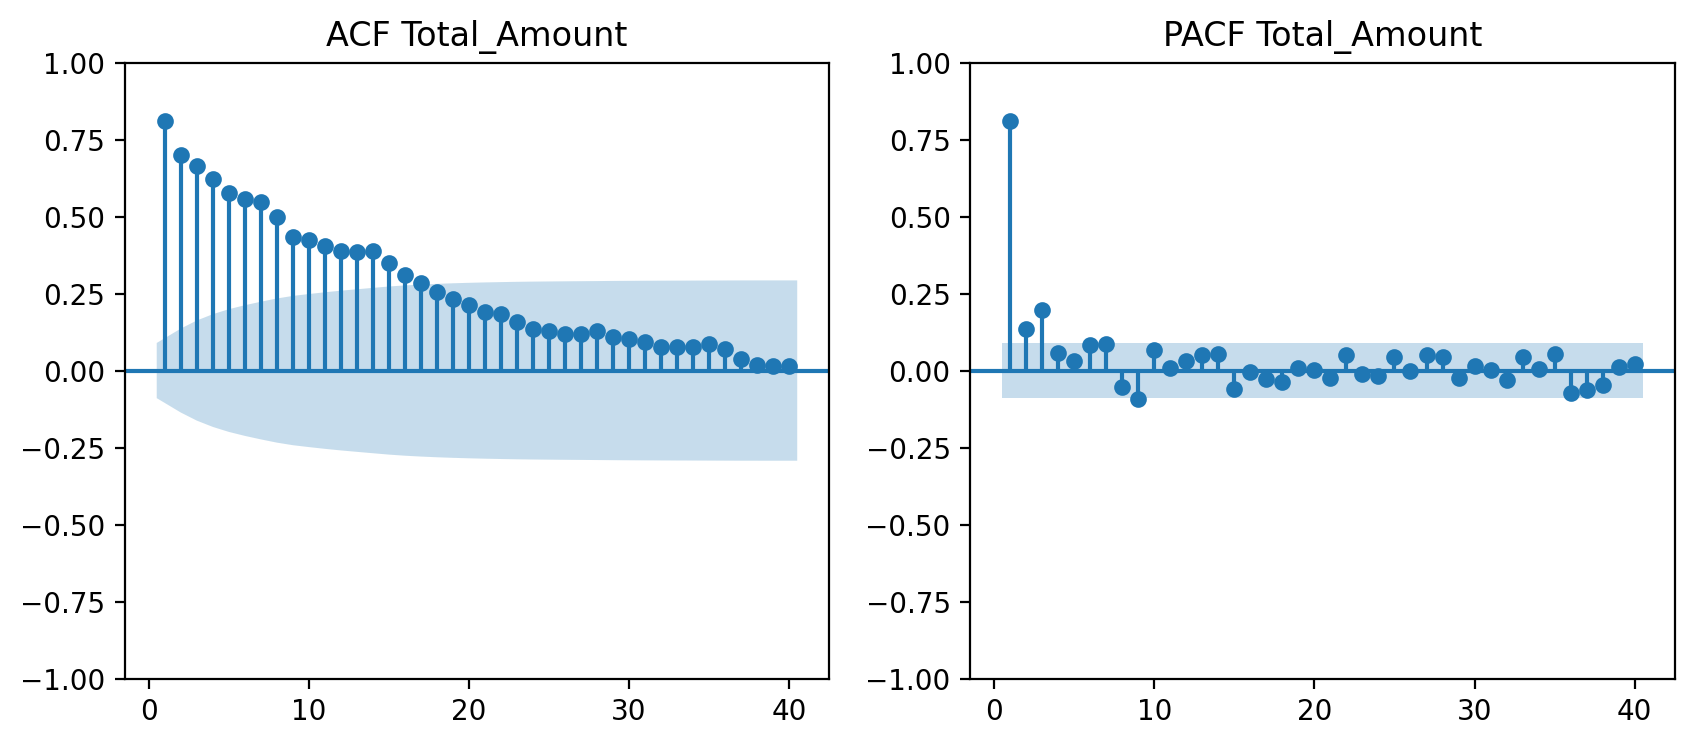

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4), dpi = 200)

sgt.plot_acf(df['total_amount'], title= 'ACF Total_Amount', lags = 40, zero= False, ax = axes[0],)
sgt.plot_pacf(df['total_amount'], title= 'PACF Total_Amount', lags = 40, zero= False, method=('ols'), ax = axes[1])
plt.show()